# Problem Statement
Your task is to build a person-name extractor for Bangla. It will take a sentence as input
and output the person name present in the input sentence. The model should also be
able to handle cases where no person’s name is present in the input sentence.

Example -

``আব্দুর রহিম নামের কাস্টমারকে একশ টাকা বাকি দিলাম``
From the above sentence, the model should extract ``আব্দুর রহিম``

# Dataset

The dataset comprises 20 text files, each containing sentences alongside corresponding tag/entity. In each file, words are paired with their respective tags. The dataset adheres to the BIO format, where an entity starts with B (Beginning). For multi-word entities, the second and subsequent words carry an I (Inside) tag. The O (Outside) tag serves as a default label for words lacking specific annotations. Here's an illustrative example:

```
Word    Tag
---------
অচল	O
হয়ে	O
পড়ছে	O
দেশের	B-LOC
অর্থনীতি	O
,	O
কমছে	O
প্রবৃদ্ধি	O
।	O

```
In the provided example, "দেশের" constitutes a complete location. The initial word is labeled as B-LOC, and subsequent words, such as "অর্থনীতি," are marked as O since they do not correspond to any specific tag.

# Exploratory Data Analysis (EDA)


In [1]:
from utils import get_token_tags
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

file_path = "annotated data/" # change it with all txt file directory
data_tags, data_tokens = get_token_tags(file_path)

Text Files: ['1.txt', '10.txt', '11.txt', '12.txt', '13.txt', '14.txt', '15.txt', '16.txt', '17.txt', '18.txt', '19.txt', '2.txt', '20.txt', '3.txt', '4.txt', '5.txt', '6.txt', '7.txt', '8.txt', '9.txt']


Median:  13.0
Average:  14.67
Min:  2
Max:  182


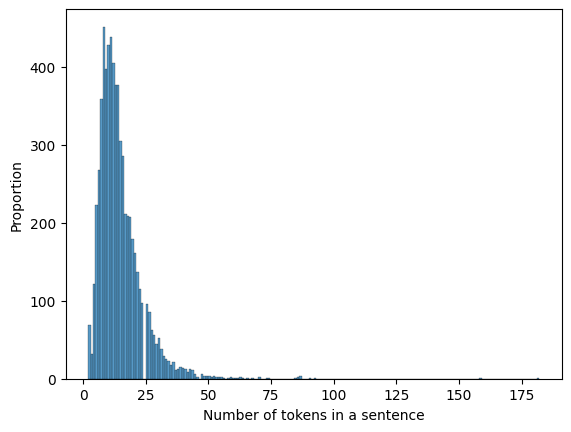

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# length distribution
lengths = list(map(lambda x: len(x), data_tokens))
sns.histplot(lengths)
plt.xlabel("Number of tokens in a sentence")
plt.ylabel("Proportion")

# print
print("Median: ", np.median(lengths))
print("Average: ", round(np.mean(lengths),2))
print("Min: ", np.min(lengths))
print("Max: ", np.max(lengths))

The median length of our sentences is 13 while the average is little above 14.67. There are some outliers. And max length is 182. We will need this information later for model's input size.

In [3]:
from collections import Counter

flattened_list = [item for sublist in data_tags for item in sublist]
count_dict = dict(Counter(flattened_list))
count_items = sorted(count_dict.items(), key=lambda x:x[1], reverse=True)
print("Number of unique tag: ", len(count_items))
print("Average count: ", round(len(flattened_list)/len(count_items)),"\n")

Number of unique tag:  8
Average count:  12030 



Meaning of tags: 
```
LOC = Geographical Entity
ORG = Organization
PER = Person
TIM = Time indicator
O = Others
B = beginning of tag
I = Inside/ending of tag
```

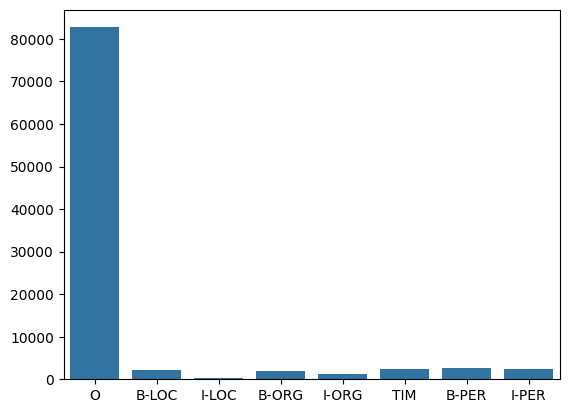

In [4]:
# bar chart
keys = list(count_dict.keys())
vals = [int(count_dict[k]) for k in keys]
sns.barplot(x=keys, y=vals)
plt.show()

Our dataset comprises 8 distinct tags, including both the B- and I- variants. Majority of tag is Others (O). And data is highly imbalanced.


The tags `B-PER` and `I-PER` indicate people's names. Prioritizing these tags is crucial for effectively addressing the challenge of distinguishing and separating individuals' names in our problem.

In [5]:
from utils import average_person_length, average_tag_presence

result = average_person_length(flattened_list)
print("Average length of Person name is:", result)

average_tag_presence(data_tags)

Average length of Person name is: 1.91
Percentage of sentences containing Peson name: 26.9%


Average length of person name is around 2. That means commnly person name has two words in this dataset. Also, only 26.9% sentances have person name. As our foucs is B-PER and I-PER tags. We can remove sentances without person name. This will reduce imbalance in dataset also.

Percentage of sentences containing Peson name: 100.0%
Number of unique tag:  8


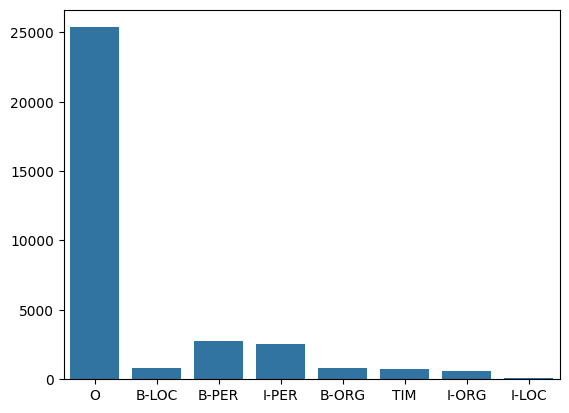

In [6]:
from utils import remove_items

# remove sentence without person name tag
remove_items(data_tokens, data_tags)

flattened_list = [item for sublist in data_tags for item in sublist]
average_tag_presence(data_tags)

count_dict = dict(Counter(flattened_list))
count_items = sorted(count_dict.items(), key=lambda x:x[1], reverse=True)
print("Number of unique tag: ", len(count_items))

# bar chart
keys = list(count_dict.keys())
vals = [int(count_dict[k]) for k in keys]
sns.barplot(x=keys, y=vals)
plt.show()

# Pre-processing

Existing stemming libs don't work for Bangla. I tried few of them. One common issue with them is - `অমর্ত্য সেন` became -> `অমর্ত্য স` after stemming. Stemming is common pre-processing in NLP still we will not use it for Bangla.

We will use vector of surrunding words for model input/features. We will try word2vec for vector. Vector will represent represent word or token.

In [7]:
from utils import get_surrounding

# trying get_surrounding function
print(data_tokens[0])
get_surrounding(data_tokens[0])

['অনেক', 'ক্ষেত্রেই', 'ভারতের', 'তুলনায়', 'বাংলাদেশের', 'সাফল্য', 'যে', 'বেশি', ',', 'নোবেলজয়ী', 'বাঙালি', 'অর্থনীতিবিদ', 'অধ্যাপক', 'অমর্ত্য', 'সেন', 'তা', 'বারবার', 'লিখেছেন', '।']


[['PAD', 'PAD', 'PAD', 'অনেক', 'ক্ষেত্রেই', 'ভারতের', 'তুলনায়'],
 ['PAD', 'PAD', 'অনেক', 'ক্ষেত্রেই', 'ভারতের', 'তুলনায়', 'বাংলাদেশের'],
 ['PAD', 'অনেক', 'ক্ষেত্রেই', 'ভারতের', 'তুলনায়', 'বাংলাদেশের', 'সাফল্য'],
 ['অনেক', 'ক্ষেত্রেই', 'ভারতের', 'তুলনায়', 'বাংলাদেশের', 'সাফল্য', 'যে'],
 ['ক্ষেত্রেই', 'ভারতের', 'তুলনায়', 'বাংলাদেশের', 'সাফল্য', 'যে', 'বেশি'],
 ['ভারতের', 'তুলনায়', 'বাংলাদেশের', 'সাফল্য', 'যে', 'বেশি', ','],
 ['তুলনায়', 'বাংলাদেশের', 'সাফল্য', 'যে', 'বেশি', ',', 'নোবেলজয়ী'],
 ['বাংলাদেশের', 'সাফল্য', 'যে', 'বেশি', ',', 'নোবেলজয়ী', 'বাঙালি'],
 ['সাফল্য', 'যে', 'বেশি', ',', 'নোবেলজয়ী', 'বাঙালি', 'অর্থনীতিবিদ'],
 ['যে', 'বেশি', ',', 'নোবেলজয়ী', 'বাঙালি', 'অর্থনীতিবিদ', 'অধ্যাপক'],
 ['বেশি', ',', 'নোবেলজয়ী', 'বাঙালি', 'অর্থনীতিবিদ', 'অধ্যাপক', 'অমর্ত্য'],
 [',', 'নোবেলজয়ী', 'বাঙালি', 'অর্থনীতিবিদ', 'অধ্যাপক', 'অমর্ত্য', 'সেন'],
 ['নোবেলজয়ী', 'বাঙালি', 'অর্থনীতিবিদ', 'অধ্যাপক', 'অমর্ত্য', 'সেন', 'তা'],
 ['বাঙালি', 'অর্থনীতিবিদ', 'অধ্যাপক', 'অমর্ত্য', 'সেন', 'তা', 'বারবার'],
 [

In [8]:
data_feature = list(get_surrounding(x,3) for x in data_tokens)
data_feature[3][:3]

[['PAD', 'PAD', 'PAD', 'সামগ্রিক', 'বিষয়ে', 'অধ্যাপক', 'ওয়াহিদউদ্দিন'],
 ['PAD', 'PAD', 'সামগ্রিক', 'বিষয়ে', 'অধ্যাপক', 'ওয়াহিদউদ্দিন', 'মাহমুদের'],
 ['PAD',
  'সামগ্রিক',
  'বিষয়ে',
  'অধ্যাপক',
  'ওয়াহিদউদ্দিন',
  'মাহমুদের',
  'বিশ্লেষণ']]

In [9]:
len(data_feature)

1765

For training Word2Vec model this dataset is not big enough and performace wise it will be poor. So I trained a word2vec model on another big dataset. I will retrain that model using this dataset.

In [10]:
from gensim.models import Word2Vec

# Load the gensim model
model_path = 'model/word2vec.model'
model = Word2Vec.load(model_path)

# update vocab and retrain model
model.build_vocab(data_tokens, update=True)
model.train(data_tokens, total_examples = len(data_tokens), epochs=10)

# similar word
print(f"vocab size : {len(model.wv.key_to_index)}")
sims = model.wv.most_similar('অমর্ত্য', topn=5)
print(f"Similar words: \n{sims}")

vocab size : 77816
Similar words: 
[('বুদ্ধদেব', 0.8233957886695862), ('কমরেড', 0.7629073262214661), ('অর্থনীতিবিদ', 0.750823974609375), ('দার্শনিক', 0.7401271462440491), ('ঔপন্যাসিক', 0.7397953867912292)]


Spliting dataset into train and test data. 80% for training and 20% for testing.

In [11]:
from sklearn.model_selection import train_test_split

data_feature = [item for sublist in data_feature for item in sublist]
label = [item for sublist in data_tags for item in sublist]
print(f"data len {len(data_feature)}, label len {len(label)}")

X_train, X_test, y_train, y_test = train_test_split(
    data_feature, label, test_size=0.2, random_state=42, stratify=label)
print(f"train data len {len(X_train)}, test data len {len(X_test)}")


data len 33724, label len 33724
train data len 26979, test data len 6745


In [12]:
from utils import row2vec

# feature words into vector
X_train = list(map(lambda x: row2vec(x, model), X_train))
X_test = list(map(lambda x: row2vec(x, model), X_test))

# list to numpy
train_X = np.array(X_train).reshape(len(X_train),-1)
test_X = np.array(X_test).reshape(len(X_test),-1)

print(train_X.shape)
print(test_X.shape)

(26979, 700)
(6745, 700)


In [13]:
import joblib

# # Save label2class
# label2class = dict(enumerate(set(y_train)))
# joblib.dump(label2class, 'model/label2class.joblib')

# Load label2class
label2class = joblib.load('model/label2class.joblib')
class2label = {value: key for key, value in label2class.items()}
label2class

{0: 'TIM',
 1: 'I-PER',
 2: 'O',
 3: 'I-ORG',
 4: 'B-LOC',
 5: 'I-LOC',
 6: 'B-ORG',
 7: 'B-PER'}

In [14]:
train_y = [class2label[tag] for tag in y_train]
test_y = [class2label[tag] for tag in y_test]

## Base-Model

We'll start with a basic model using Random Forest. After that, we'll work on enhancing its performance through further improvements and adjustments. For evaluation we will use not only `accuracy` but also `f1-score` as our data is imbalanced. 

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import joblib

classifier = RandomForestClassifier()
param_grid = {"n_estimators":[50],
              "max_depth":[30], "min_samples_leaf":[3]}

cv = GridSearchCV(classifier,
                  param_grid=param_grid,
                  n_jobs=-1,
                  scoring="f1_macro",
                  cv=3,
                  verbose=True)
cv.fit(train_X, train_y)

classifier = cv.best_estimator_
print(cv.best_params_)
print(cv.best_score_)

# Save the model to a file
joblib.dump(classifier, 'model/random_forest_model.joblib')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
{'max_depth': 30, 'min_samples_leaf': 3, 'n_estimators': 50}
0.5911106936489471


['model/random_forest_model.joblib']

In [16]:
from sklearn.metrics import classification_report

# Generate a classification report
y_pred = classifier.predict(test_X)
report = classification_report(test_y, y_pred, target_names=label2class.values())
print(report)

              precision    recall  f1-score   support

         TIM       0.95      0.79      0.86       151
       I-PER       0.95      0.74      0.83       502
           O       0.88      0.99      0.94      5073
       I-ORG       0.88      0.38      0.53       114
       B-LOC       0.85      0.39      0.53       169
       I-LOC       0.00      0.00      0.00        25
       B-ORG       0.87      0.37      0.52       159
       B-PER       0.91      0.54      0.68       552

    accuracy                           0.89      6745
   macro avg       0.79      0.52      0.61      6745
weighted avg       0.89      0.89      0.87      6745



In [17]:
from utils import get_name

names, tags = get_name("আব্দুর রহিম নামের কাস্টমারকে একশ টাকা বাকি দিলাম", model, classifier, label2class, False)
print(tags)
names, tags = get_name("যুবলীগের কর্মী মাসুম ছাত্রদলের কর্মী সাদ্দামকে গুলি করেন", model, classifier, label2class, False)
print(tags)


Given sentence: আব্দুর রহিম নামের কাস্টমারকে একশ টাকা বাকি দিলাম
Extracted names: 
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Given sentence: যুবলীগের কর্মী মাসুম ছাত্রদলের কর্মী সাদ্দামকে গুলি করেন
Extracted names: মাসুম 
['O', 'O', 'I-PER', 'B-ORG', 'O', 'O', 'O', 'O']


The classification report indicates an overall accuracy of 89%, but the F1-score (Macro) is lower at 61%. Which is not bad for base-model. 

Upon closer inspection, it seems the model tends to predict most words as "O". This behavior may stem from an imbalanced dataset, where the "O" category dominates. To address this, considering under-sampling of the "O" tag could help balance the data and potentially improve the model's performance on other categories.

## Under-sampling

In [18]:
# print(label2class)
count_dict = dict(Counter(train_y))
count_dict = {label2class[key]:value for key, value in count_dict.items()}
print(count_dict)

{'O': 20291, 'B-PER': 2206, 'I-PER': 2009, 'I-ORG': 457, 'TIM': 603, 'I-LOC': 102, 'B-ORG': 634, 'B-LOC': 677}


Our main interest lies in 'B-PER' and 'I-PER' tags, which represent person names. To ensure a balanced dataset, I'll select up to 2206 samples for each of these tags. For tags with fewer than 2206 samples, we can overlook them as they are not our primary focus. This approach helps prioritize and maintain a more focused dataset for training or evaluation.

In [19]:
from utils import random_indices_by_category

idx = random_indices_by_category(train_y, 2206)
train_y_sampling = [train_y[i] for i in idx]
train_X_sampling = train_X[idx]

count_dict = dict(Counter(train_y_sampling))
count_dict = {label2class[key]:value for key, value in count_dict.items()}

print("After sampling:", count_dict)

After sampling: {'TIM': 603, 'I-PER': 2009, 'O': 2206, 'I-ORG': 457, 'B-LOC': 677, 'I-LOC': 102, 'B-ORG': 634, 'B-PER': 2206}


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import joblib

classifier = RandomForestClassifier()
param_grid = {"n_estimators":[50],
              "max_depth":[30], "min_samples_leaf":[3]
              }

cv = GridSearchCV(classifier,
                  param_grid=param_grid,
                  n_jobs=-1,
                  scoring="f1_macro",
                  cv=3,
                  verbose=True)
cv.fit(train_X_sampling, train_y_sampling)

classifier = cv.best_estimator_
print(cv.best_params_)
print(cv.best_score_)
# Save the model to a file
joblib.dump(classifier, 'model/sampling_random_forest_model.joblib')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
{'max_depth': 30, 'min_samples_leaf': 3, 'n_estimators': 50}
0.684227194882605


['model/sampling_random_forest_model.joblib']

In [25]:
from sklearn.metrics import classification_report

# Generate a classification report
y_pred = classifier.predict(test_X)
report = classification_report(test_y, y_pred, target_names=label2class.values())
print(report)

              precision    recall  f1-score   support

         TIM       0.88      0.86      0.87       151
       I-PER       0.74      0.93      0.82       502
           O       0.96      0.86      0.91      5073
       I-ORG       0.70      0.52      0.60       114
       B-LOC       0.64      0.71      0.67       169
       I-LOC       0.67      0.16      0.26        25
       B-ORG       0.74      0.46      0.57       159
       B-PER       0.46      0.89      0.61       552

    accuracy                           0.84      6745
   macro avg       0.73      0.67      0.66      6745
weighted avg       0.88      0.84      0.85      6745



In [22]:
names, tags = get_name("আব্দুর রহিম নামের কাস্টমারকে একশ টাকা বাকি দিলাম", model, classifier, label2class, False)
print(tags)
names, tags = get_name("যুবলীগের কর্মী মাসুম ছাত্রদলের কর্মী সাদ্দামকে গুলি করেন", model, classifier, label2class, False)
print(tags)
names, tags = get_name("বন্দর থানার ভারপ্রাপ্ত কর্মকর্তা সঞ্জয় সিনহা বলেন", model, classifier, label2class, False)
print(tags)

Given sentence: আব্দুর রহিম নামের কাস্টমারকে একশ টাকা বাকি দিলাম
Extracted names: আব্দুর রহিম ,বাকি 
['B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'B-PER', 'O']
Given sentence: যুবলীগের কর্মী মাসুম ছাত্রদলের কর্মী সাদ্দামকে গুলি করেন
Extracted names: মাসুম ,সাদ্দামকে 
['I-ORG', 'O', 'I-PER', 'B-ORG', 'O', 'B-PER', 'O', 'O']
Given sentence: বন্দর থানার ভারপ্রাপ্ত কর্মকর্তা সঞ্জয় সিনহা বলেন
Extracted names: সঞ্জয় সিনহা 
['O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O']


While undersampling has enhanced the F1-score 66%, the model still faces challenges in recognizing new names/words not present in the dataset. This indicates a limitation in the model's ability to generalize to unseen data. Also, accuracy reduce to 84%.

To address this issue, I will use more complex model like ANN.

## Deep Learning

I've decided to employ a straightforward multiple-layer Artificial Neural Network (ANN). Since our dataset isn't very large, opting for a simpler model without too many complex layers and parameters is a wise choice. This approach aims to strike a balance between model complexity and the available data for effective learning.

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

num_classes = 8

# Define the model
ann_model = Sequential()
ann_model.add(Dense(256, input_dim=train_X.shape[1], activation='relu'))
ann_model.add(BatchNormalization())
ann_model.add(Dropout(0.5))
ann_model.add(Dense(128, activation='relu'))
ann_model.add(BatchNormalization())
ann_model.add(Dropout(0.5))
ann_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
ann_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])


# Define an EarlyStopping callback
early_stopping = EarlyStopping(monitor='loss',
                               patience=5,
                               restore_best_weights=True,
                               verbose=False)

# Train the model with EarlyStopping callback
history = ann_model.fit(train_X, np.array(train_y),
                        epochs=200,
                        batch_size=64,
                        validation_split=0.15,
                        callbacks=[early_stopping])

In [27]:
# save model
# ann_model.save("model/trained_ann_model.h5")
ann_model.load_weights("model/trained_ann_model.h5")

# Generate a classification report
y_pred = ann_model.predict(test_X)
y_pred_classes = tf.argmax(y_pred, axis=1)
report = classification_report(test_y, y_pred_classes, target_names=label2class.values())
print(report)


211/211 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

         TIM       0.92      0.81      0.86       151
       I-PER       0.87      0.83      0.85       502
           O       0.93      0.96      0.94      5073
       I-ORG       0.75      0.58      0.65       114
       B-LOC       0.69      0.54      0.61       169
       I-LOC       0.47      0.28      0.35        25
       B-ORG       0.64      0.48      0.55       159
       B-PER       0.77      0.70      0.74       552

    accuracy                           0.90      6745
   macro avg       0.75      0.65      0.69      6745
weighted avg       0.89      0.90      0.89      6745



In [28]:
names, tags = get_name("আব্দুর রহিম নামের কাস্টমারকে একশ টাকা বাকি দিলাম", model, ann_model, label2class)
names, tags = get_name("যুবলীগের কর্মী মাসুম ছাত্রদলের কর্মী সাদ্দামকে গুলি করেন", model, ann_model, label2class)
names, tags = get_name("বন্দর থানার ভারপ্রাপ্ত কর্মকর্তা সঞ্জয় সিনহা বলেন", model, ann_model, label2class)

Given sentence: আব্দুর রহিম নামের কাস্টমারকে একশ টাকা বাকি দিলাম
Extracted names: আব্দুর রহিম 
Given sentence: যুবলীগের কর্মী মাসুম ছাত্রদলের কর্মী সাদ্দামকে গুলি করেন
Extracted names: মাসুম ,সাদ্দামকে 
Given sentence: বন্দর থানার ভারপ্রাপ্ত কর্মকর্তা সঞ্জয় সিনহা বলেন
Extracted names: সঞ্জয় সিনহা 


ANN got 90% accuracy and 69% f1-score. Whiche is better than initial base-model. Also, it working for words/names not existing in both training and testing dataset. It also working for multiple name in same sentence. Considering time I think we can stop EDA here.

# Future work 
- add more dataset for better model
- try more complex model like LSTM, BERT
- better feature engineering
- using bigger word2vec model